In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (11,5)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/IDUG_Charlotte_2024/DB2-IDBDCPUT-0504S.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format="%d/%m/%Y %H:%M:%S")
df['DATE'] = df['TIMESTAMP'].dt.strftime('%d/%m/%Y')
df['TIME'] = df['TIMESTAMP'].dt.strftime('%H:%M:%S')
df.dtypes

TIMESTAMP    datetime64[ns]
IDBDCPUT            float64
DATE                 object
TIME                 object
dtype: object

In [ ]:
df.head()

,TIMESTAMP,IDBDCPUT,DATE,TIME
0,2024-04-05 12:00:00,14.801119,05/04/2024,12:00:00
1,2024-04-05 12:01:00,13.197293,05/04/2024,12:01:00
2,2024-04-05 12:02:00,11.946425,05/04/2024,12:02:00
3,2024-04-05 12:03:00,19.998539,05/04/2024,12:03:00
4,2024-04-05 12:04:00,23.805432,05/04/2024,12:04:00


In [ ]:
df.tail()

,TIMESTAMP,IDBDCPUT,DATE,TIME
356,2024-04-05 17:56:00,5.115353,05/04/2024,17:56:00
357,2024-04-05 17:57:00,2.414358,05/04/2024,17:57:00
358,2024-04-05 17:58:00,5.489411,05/04/2024,17:58:00
359,2024-04-05 17:59:00,3.846366,05/04/2024,17:59:00
360,2024-04-05 18:00:00,8.396365,05/04/2024,18:00:00


In [ ]:
df.describe()

,TIMESTAMP,IDBDCPUT
count,361,361.000000
mean,2024-04-05 15:00:00.000000256,12.902163
min,2024-04-05 12:00:00,0.042191
25%,2024-04-05 13:30:00,5.489411
50%,2024-04-05 15:00:00,10.305060
75%,2024-04-05 16:30:00,19.980080
max,2024-04-05 18:00:00,53.991751
std,NaN,8.627902


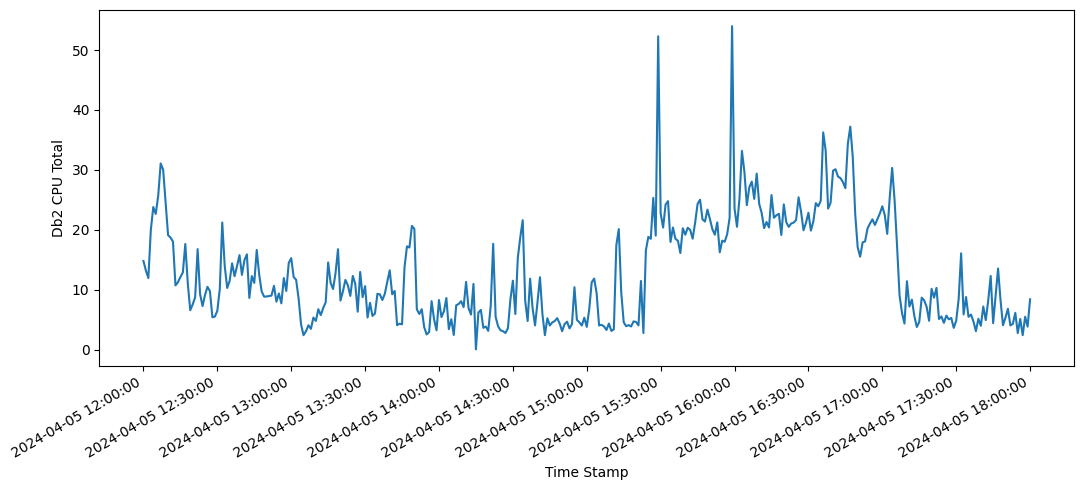

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['TIMESTAMP'], df['IDBDCPUT'])
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Db2 CPU Total')
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

# Convert the string arguments to datetime objects
start_date = np.datetime64('2024-04-05 12:00:00')
end_date = np.datetime64('2024-04-05 18:01:00')

# Use the datetime objects with np.arange()
xticks = np.arange(start_date, end_date, 1800)

# Set the xticks on the plot
plt.xticks(xticks)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ADF_result = adfuller(df['IDBDCPUT'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.2537664633853196
p-value: 0.18731280708845338


You should get a p-value greater than 0.05, meaning that we fail to reject the null hypothesis and conclude that the series is not stationary.

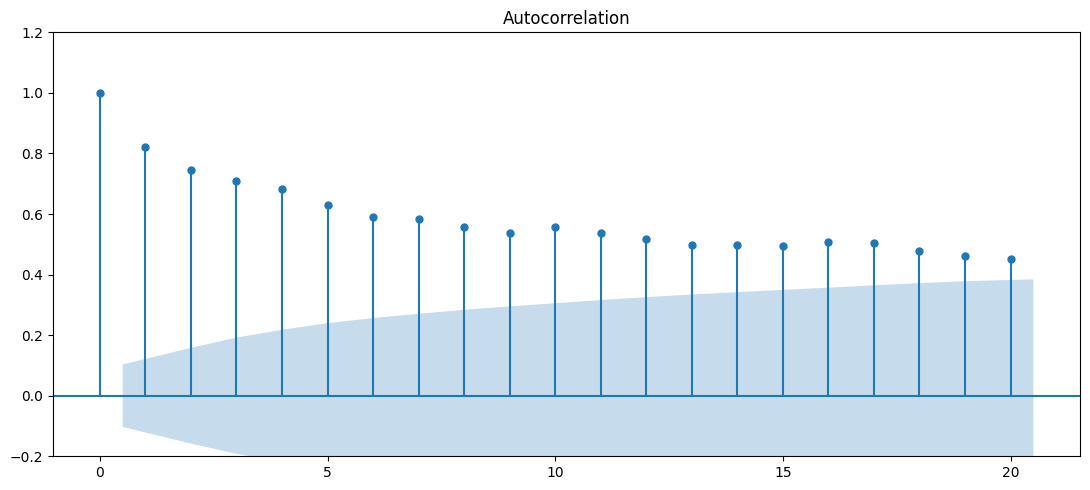

In [ ]:
plot_acf(df['IDBDCPUT'], lags=20);

plt.ylim(-0.2, 1.2)
plt.tight_layout()

In [ ]:
series_diff = np.diff(df['IDBDCPUT'], n=1)

In [ ]:
ADF_result = adfuller(series_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -9.70261897812648
p-value: 1.0622400124744452e-16


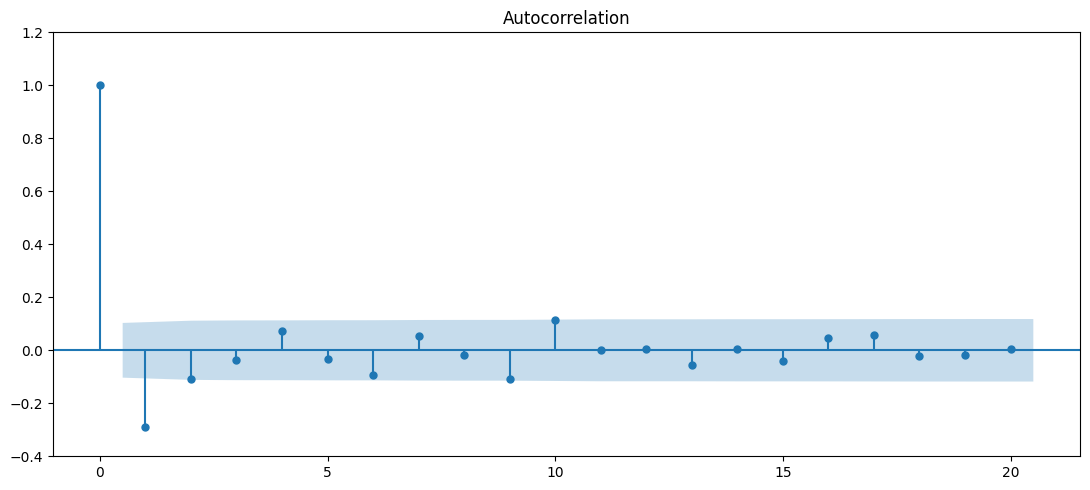

In [ ]:
plot_acf(series_diff, lags=20);

plt.ylim(-0.4, 1.2)
plt.tight_layout()

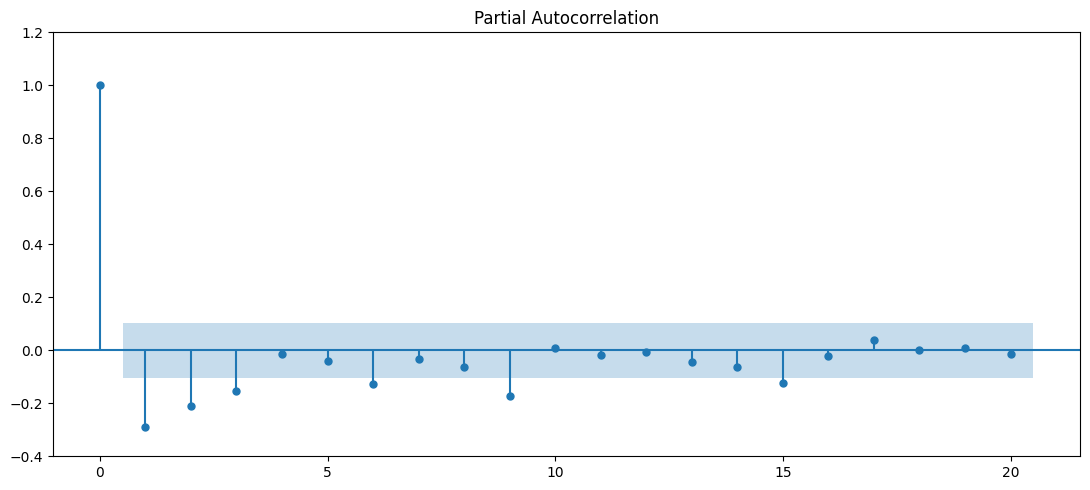

In [ ]:
plot_pacf(series_diff, lags=20);

plt.ylim(-0.4, 1.2)
plt.tight_layout()

In [ ]:
df_diff = pd.DataFrame({'values': series_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(len(train))
print(len(test))

260
100


In [ ]:
df_diff

,values
0,-1.603826
1,-1.250868
2,8.052114
3,3.806893
4,-1.162620
...,...
355,2.351139
356,-2.700995
357,3.075053
358,-1.643045


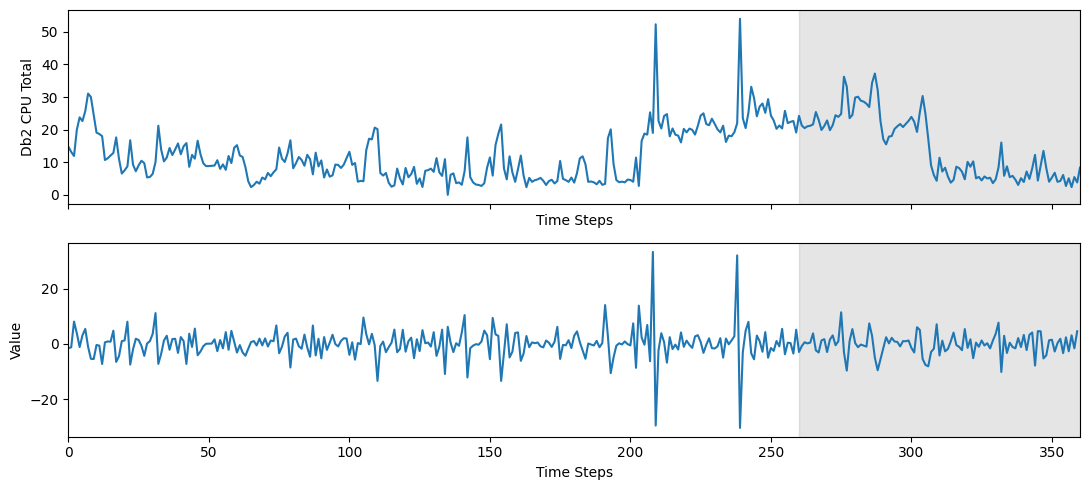

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['IDBDCPUT'])
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Db2 CPU Total')
ax1.axvspan(260, 360, color='#808080', alpha=0.2)
ax1.set_xlim(0, 360)

ax2.plot(df_diff['values'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Value')
ax2.axvspan(260, 360, color='#808080', alpha=0.2)
ax2.set_xlim(0, 360)

plt.tight_layout()

In [ ]:
def rolling_predictions(df_diff, last_train_value, train_len, horizon, window, method):

    TOTAL_LEN = train_len + horizon
    if method == 'MA':
        pred_MA = []

        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(0,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:] * -1
            pred_MA.extend(oos_pred)

        last_train_value = np.array([last_train_value])
        pred_MA = np.concatenate((last_train_value, pred_MA))
        pred_MA = pred_MA.cumsum()

        return pred_MA[:100]

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:] * -1
            pred_AR.extend(oos_pred)

        last_train_value = np.array([last_train_value])
        pred_AR = np.concatenate((last_train_value, pred_AR))
        pred_AR = pred_AR.cumsum()

        return pred_AR[:100]

In [ ]:
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[259].IDBDCPUT

windows = [1]

for window in windows:
    pred_MA = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'MA')
    pred_AR = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'AR')
    pred_df[f'pred_MA_{window}'] = pred_MA
    pred_df[f'pred_AR_{window}'] = pred_AR

pred_df.head()

,TIMESTAMP,IDBDCPUT,DATE,TIME,pred_MA_1,pred_AR_1
261,2024-04-05 16:21:00,21.287241,05/04/2024,16:21:00,19.135260,19.135260
262,2024-04-05 16:22:00,20.490201,05/04/2024,16:22:00,20.847703,20.417371
263,2024-04-05 16:23:00,21.045079,05/04/2024,16:23:00,20.200555,20.039946
264,2024-04-05 16:24:00,21.206927,05/04/2024,16:24:00,19.449346,19.609429
265,2024-04-05 16:25:00,21.644510,05/04/2024,16:25:00,19.347264,19.165047


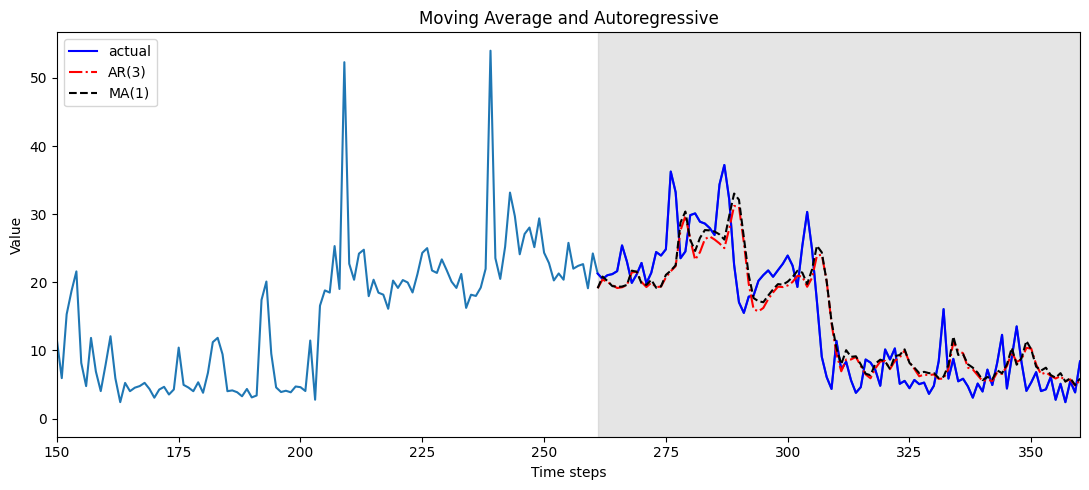

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['IDBDCPUT'])
ax.plot(pred_df['IDBDCPUT'], 'b-', label='actual')
ax.plot(pred_df[f'pred_AR_1'], 'r-.', label='AR(3)')
ax.plot(pred_df[f'pred_MA_1'], 'k--', label='MA(1)')

ax.legend(loc=2)
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')
ax.axvspan(261, 360, color='#808080', alpha=0.2)
ax.set_xlim(150, 360)
ax.set_title(f'Moving Average and Autoregressive')

plt.tight_layout()